In [ ]:
import nest_asyncio
nest_asyncio.apply()
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import math
import stan
import arviz as az

In [ ]:
def dummy_seasonal(series_len, seasonality, duration=1, seed=None, seeded=False):
    """ 
    Get seasonal effects that sum to 0 over seasonal period
    Assumes N(0,1) distribution
    If you want specific effect, the scale is specified in the code for the simulations
    Called within the local level and local level trend functions
    """
    
    if seeded:
        np.random.seed(seed)

    seas = []
    iterations = math.ceil(series_len / duration)
    init_seas = np.zeros(seasonality)

    init_seas[:-1] = np.random.normal(
        0, 1, seasonality - 1
    )

    init_seas[seasonality - 1] = -1 * np.sum(init_seas) 
    # ^^^^ IDK if this IS cheating, but just generating them and then replacing one so they sum to 0 seems like cheating! 
    # But it fulfills the requirements of a seasonal proccess

    for idx in range(iterations):
        seas += [init_seas[idx % seasonality]] * duration
    seas = np.array(seas[:series_len])
    
    return seas

def plot_local_level(model, size=(7,4)):

    y = model['y']
    mu = model['mu']

    fig, ax = plt.subplots(1, figsize=size)
    ax.plot(y, label='y', color='k', alpha=.6)
    ax.plot(mu, label = 'level', color='darkorange')
    fig.legend()
    plt.tight_layout()

def plot_local_level_seasonal(model, size=(7,4)):

    y = model['y']
    mu = model['mu']
    seasonal = model['seasonal']

    fig, ax = plt.subplots(2, figsize=size)
    ax[0].plot(y, label='y', color='k', alpha=.6)
    ax[0].plot(mu, label = 'level', color='darkorange')
    ax[1].plot(seasonal, label='seasonal', color="navy")
    fig.legend()
    plt.tight_layout()

def plot_level_trend(model, size=(7,4)):

    y = model['y']
    mu = model['mu']
    delta = model['delta']

    fig, ax = plt.subplots(2, figsize=size)
    ax[0].plot(y, label='y', color='k', alpha=.6)
    ax[0].plot(mu, label = 'level', color='darkorange')
    ax[1].plot(delta, label="slope", color='k')
    fig.legend()
    plt.tight_layout()

def plot_level_trend_seasonal(model, size=(7,4)):

    y = model['y']
    mu = model['mu']
    delta = model['delta']
    seasonal = model['seasonal']

    fig, ax = plt.subplots(3, figsize=size)
    ax[0].plot(y, label='y', color='k', alpha=.6)
    ax[0].plot(mu, label = 'level', color='darkorange')
    ax[1].plot(delta, label="slope", color='k')
    ax[2].plot(seasonal, label='seasonal', color="navy")
    fig.legend()
    plt.tight_layout()

def plot_intervention_weights(model, size=(10,4)):

    y = model['y_new']
    intervention_weights = model['intervention_weights']

    fig, ax = plt.subplots(2, figsize=size)
    ax[0].plot(y, alpha=1, label="y", color='k', )
    ax[1].plot(intervention_weights, alpha=1, label="intervention weight")
    fig.legend()
    plt.tight_layout()

def local_level_trend_seasonal(
    num_timesteps=100, 
    init_mu=0, 
    init_delta=.5,
    s_obs = 2, 
    s_mu=.1, 
    s_delta = .05,
    s_seasonal= .01,
    seasonality = 12,
    stochastic_seasonal=True,
    seasonal_factor=1,
    seeded=True, 
    seed=5,
    stochastic_delta=True
    ):

    """ returns dictionary of simulated state space model components"""
    
    if seeded:
        np.random.seed(seed)
    
    mu = np.zeros(num_timesteps+1)
    delta = np.zeros(num_timesteps+1)
    y = np.zeros(num_timesteps)
    
    mu_err = np.random.normal(loc=0, scale=1, size=num_timesteps)
    obs_err = np.random.normal(loc=0, scale=1, size=num_timesteps)
    delta_err = np.random.normal(loc=0, scale=1, size=num_timesteps)
    seasonal_err = np.random.normal(loc=0, scale=1, size=num_timesteps)

    # Seasonal Effects
    seasonal = dummy_seasonal(num_timesteps, seasonality, 1, seed=seed, seeded=seeded)
    seasonal = seasonal * seasonal_factor

    # Get seasonal effects
    mu[0] = init_mu
    delta[0] = init_delta

    for t in range(num_timesteps): 
        
        # Level State Equation 
        mu[t+1] = mu[t] + delta[t] + s_mu * mu_err[t] 

        # Slope State Equation 
        if stochastic_delta==False: 
            delta[t+1] = delta[t] 
        elif stochastic_delta == True: 
            delta[t+1] = delta[t] + s_delta * delta_err[t] 
        
        # Seasonal Equation
        if stochastic_seasonal==False:
            seasonal[t] = seasonal[t]
        elif stochastic_seasonal==True:
            seasonal[t] = seasonal[t] + s_seasonal * seasonal_err[t]
        
        # Observation Equation
        y[t] = mu[t] + seasonal[t] + s_obs * obs_err[t]

    return { 'y': y, 'mu': mu, 'delta': delta ,'seasonal': seasonal} 

In [ ]:
sim = local_level_trend_seasonal(100, init_mu=10., s_obs=10, s_mu=5, s_delta=.1, 
                                 init_delta=1,  seasonality=12, s_seasonal=.1, 
                                 seasonal_factor=10, seeded=True, seed=1)
plot_level_trend_seasonal(sim)

In [ ]:
level_code = """
data {
  int<lower=0> N;         // # observations
  real y[N];              // observations
}

transformed data {                                                                       
  real sd_y = sd(y);      
  real scale_error = 10 * sd_y;                                                               
}

parameters {

  vector[N] mu_err;       // level innovation
  vector[N] delta_err;       // delta innovation
  vector[N] season_err;       // delta innovation

  real<lower=0> s_level;
  real<lower=0> s_obs;
  real<lower=0> s_delta;
  real<lower=0> s_season;
  // real<lower=0> sigma_y;
}

transformed parameters {

  vector[N] mu;           // level 
  vector[N] delta;        // slope
  vector[N] seasonal;     // seasonality

  real<lower=0> sigma_y = scale_error * s_obs;

  // initialize first values for latent states
  mu[1] = mu_err[1];                  // initialize level
  delta[1] = delta_err[1];            // initialize delta
  seasonal[1:11] = season_err[1:11];  // initialize empty seasonal

  // state transitions
  for (t in 2:N) {
    mu[t] = mu[t-1] + delta[t-1] + s_level * mu_err[t];
    delta[t] = delta[t-1] + s_delta * delta_err[t];
  }

  // seasonal components
  for(t in 12:N) {
    seasonal[t] = -sum(seasonal[t-11:t-1]) + s_season * season_err[t];
  }
}

model {
  mu_err ~ normal(0,1);
  delta_err ~ normal(0,1);
  season_err ~ normal(0,1);

  // s_obs ~ normal(5, 5);
  // s_level ~ normal(5, 5);
  s_delta ~ inv_gamma(2, .5);
  s_season ~ inv_gamma(.5, .1);

  y ~ normal(mu + seasonal, scale_error);
}

generated quantities {
  vector[N] y_hat;
  
  for (t in 1:N) {
    y_hat[t] = normal_rng(mu[t] + seasonal[t], s_obs);
  }
}

"""

In [108]:
level_code = """
data {
  int<lower=0> N;         // # observations
  real y[N];              // observations
}

parameters {

  vector[N] mu_err;       // level innovation
  vector[N] delta_err;       // delta innovation
  vector[N] season_err;       // delta innovation

  real<lower=0> s_level;
  real<lower=0> s_obs;
  real<lower=0> s_delta;
  real<lower=0> s_season;
}

transformed parameters {

  vector[N] mu;           // level 
  vector[N] delta;        // slope
  vector[N] seasonal;     // seasonality

  // initialize first values for latent states
  mu[1] = mu_err[1];                  // initialize level
  delta[1] = delta_err[1];            // initialize delta
  seasonal[1:11] = season_err[1:11];  // initialize empty seasonal

  // state transitions
  for (t in 2:N) {
    mu[t] = mu[t-1] + delta[t-1] + s_level * mu_err[t];
    delta[t] = delta[t-1] + s_delta * delta_err[t];
  }

  // seasonal components
  for(t in 12:N) {
    seasonal[t] = -sum(seasonal[t-11:t-1]) + s_season * season_err[t];
  }
}

model {
  mu_err ~ normal(0,1);
  delta_err ~ normal(0,1);
  season_err ~ normal(0,1);

  s_obs ~ normal(5, 5);
  s_level ~ normal(5, 5);
  s_delta ~ inv_gamma(2, .5);
  s_season ~ inv_gamma(1, .01);

  y ~ normal(mu + seasonal, s_obs);
}

generated quantities {
  vector[N] y_hat;
  
  for (t in 1:N) {
    y_hat[t] = normal_rng(mu[t] + seasonal[t], s_obs);
  }
}

"""

In [ ]:
y = sim['y']
N = len(y)
level_data = {"N": N,
                "y": y,}


In [109]:
model = stan.build(level_code, data=level_data, random_seed=1)

Building...

/home/woejozney/.cache/httpstan/4.9.1/models/wtkpf64c/model_wtkpf64c.cpp: In constructor ‘model_wtkpf64c_namespace::model_wtkpf64c::model_wtkpf64c(stan::io::var_context&, unsigned int, std::ostream*)’:
/home/woejozney/.cache/httpstan/4.9.1/models/wtkpf64c/model_wtkpf64c.cpp:88:11: warning: variable ‘pos__’ set but not used [-Wunused-but-set-variable]
   88 |       int pos__ = std::numeric_limits<int>::min();
      |           ^~~~~
In file included from /home/woejozney/miniconda3/envs/ds/lib/python3.10/site-packages/httpstan/include/stan/math/prim/fun.hpp:124,
                 from /home/woejozney/miniconda3/envs/ds/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun/multiply.hpp:7,
                 from /home/woejozney/miniconda3/envs/ds/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun/elt_multiply.hpp:9,
                 from /home/woejozney/miniconda3/envs/ds/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun.hpp:55,
                 from /hom


Building: 12.1s, done.Messages from stanc:
Warning in '/tmp/httpstan_i_wcgx89/model_wtkpf64c.stan', line 4, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/httpstan_i_wcgx89/model_wtkpf64c.stan', line 50, column 26: Argument
    .01 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).


In [110]:
posterior = model.sample(num_chains=4, num_samples=1000)

Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling:  29% (2300/8000)
Sampling:  30% (2400/8000)
Sampling:  31% (2500/8000)
Sampling:  32% (2600/8000)
Sampling:  34% (2700/8000)
Sampling:  35% (2800/8000)
Sampling:  36% (2900/8000)
Sampling:  38% (3000/8000)
Sampling:  39% (3100/8000)
Sampling:  40% (3200/8000)
Sampling:  41% (3300/8000)
Samplin

In [106]:
idata = az.from_pystan(posterior=posterior, posterior_predictive=["y_hat"], 
                       posterior_model=model, observed_data=['y'],
                       save_warmup=False)

fitsum = az.summary(posterior)
fitsum

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_err[0],0.471,0.996,-1.552,2.302,0.014,0.016,4840.0,2163.0,1.0
mu_err[1],0.951,0.892,-0.631,2.748,0.017,0.012,3042.0,2502.0,1.0
mu_err[2],0.338,0.902,-1.257,2.095,0.013,0.014,4622.0,2840.0,1.0
mu_err[3],0.118,0.942,-1.655,1.867,0.015,0.016,3960.0,2220.0,1.0
mu_err[4],-0.030,0.931,-1.898,1.614,0.013,0.015,4731.0,2966.0,1.0
...,...,...,...,...,...,...,...,...,...
y_hat[95],119.095,13.193,93.186,142.511,0.212,0.150,3895.0,4021.0,1.0
y_hat[96],152.272,13.432,126.844,177.545,0.204,0.145,4322.0,3968.0,1.0
y_hat[97],125.408,13.248,100.817,150.180,0.203,0.144,4241.0,4002.0,1.0
y_hat[98],135.548,13.540,111.525,162.512,0.199,0.141,4621.0,4154.0,1.0


In [111]:
np.mean(idata.sample_stats['diverging'])

<xarray.DataArray 'diverging' ()>
array(0.0325)

array([[<AxesSubplot: title={'center': 's_obs'}>,
        <AxesSubplot: title={'center': 's_obs'}>],
       [<AxesSubplot: title={'center': 's_delta'}>,
        <AxesSubplot: title={'center': 's_delta'}>],
       [<AxesSubplot: title={'center': 's_level'}>,
        <AxesSubplot: title={'center': 's_level'}>],
       [<AxesSubplot: title={'center': 's_season'}>,
        <AxesSubplot: title={'center': 's_season'}>]], dtype=object)

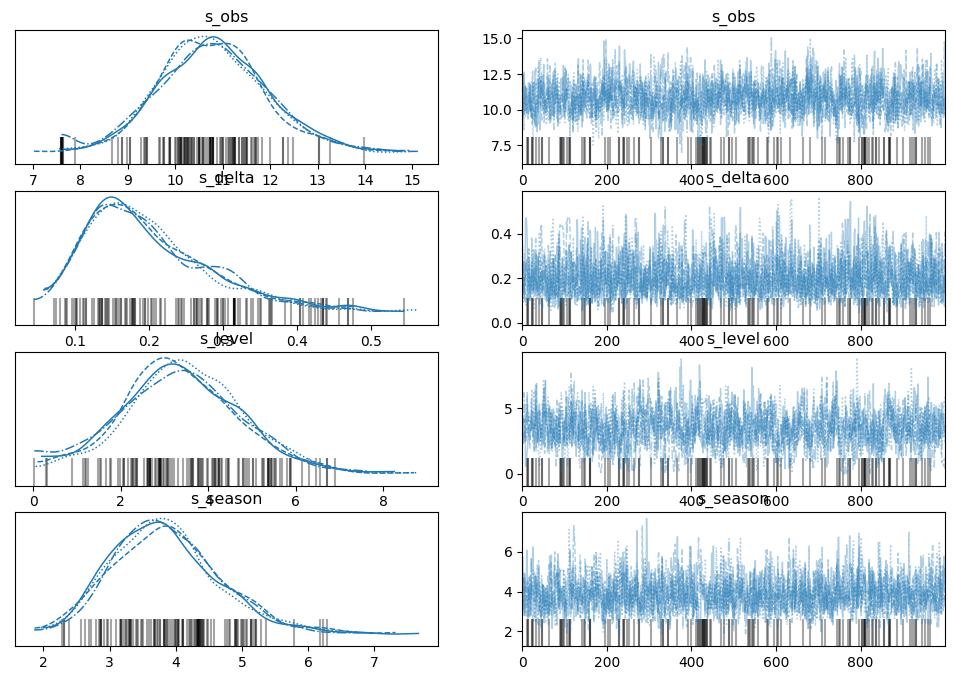

In [112]:
az.plot_trace(idata, var_names=("s_obs", "s_delta", "s_level", "s_season"))

array([[<AxesSubplot: title={'center': 's_obs'}>,
        <AxesSubplot: title={'center': 's_obs'}>],
       [<AxesSubplot: title={'center': 's_delta'}>,
        <AxesSubplot: title={'center': 's_delta'}>],
       [<AxesSubplot: title={'center': 's_level'}>,
        <AxesSubplot: title={'center': 's_level'}>],
       [<AxesSubplot: title={'center': 's_season'}>,
        <AxesSubplot: title={'center': 's_season'}>]], dtype=object)

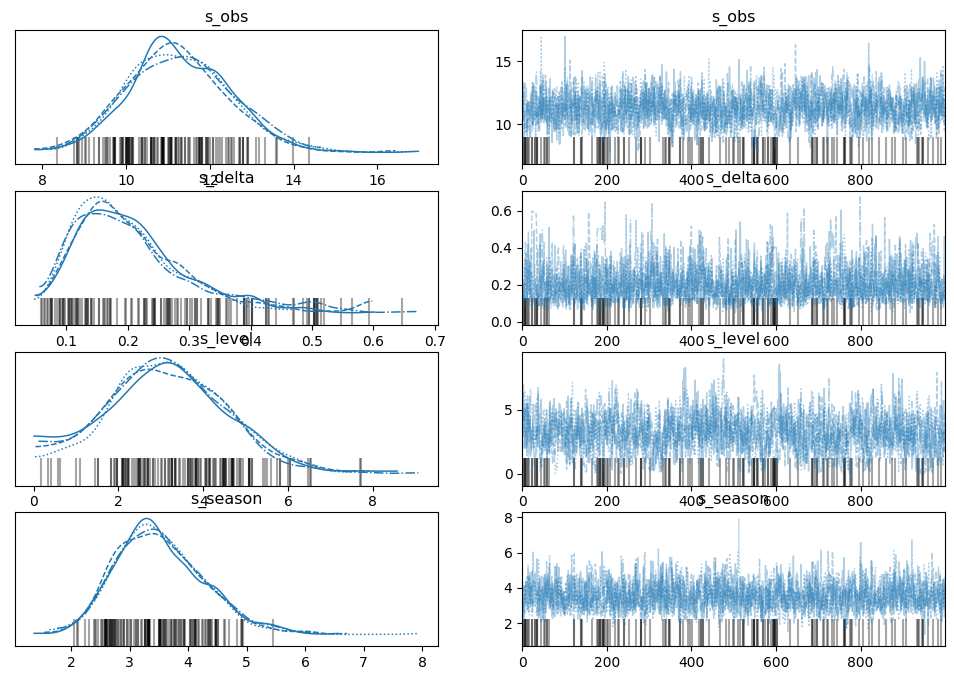

In [84]:
az.plot_trace(idata, var_names=("s_obs", "s_delta", "s_level", "s_season"))

array([[<AxesSubplot: ylabel='s_delta'>, <AxesSubplot: >,
        <AxesSubplot: >],
       [<AxesSubplot: ylabel='s_level'>, <AxesSubplot: >,
        <AxesSubplot: >],
       [<AxesSubplot: xlabel='s_obs', ylabel='s_season'>,
        <AxesSubplot: xlabel='s_delta'>, <AxesSubplot: xlabel='s_level'>]],
      dtype=object)

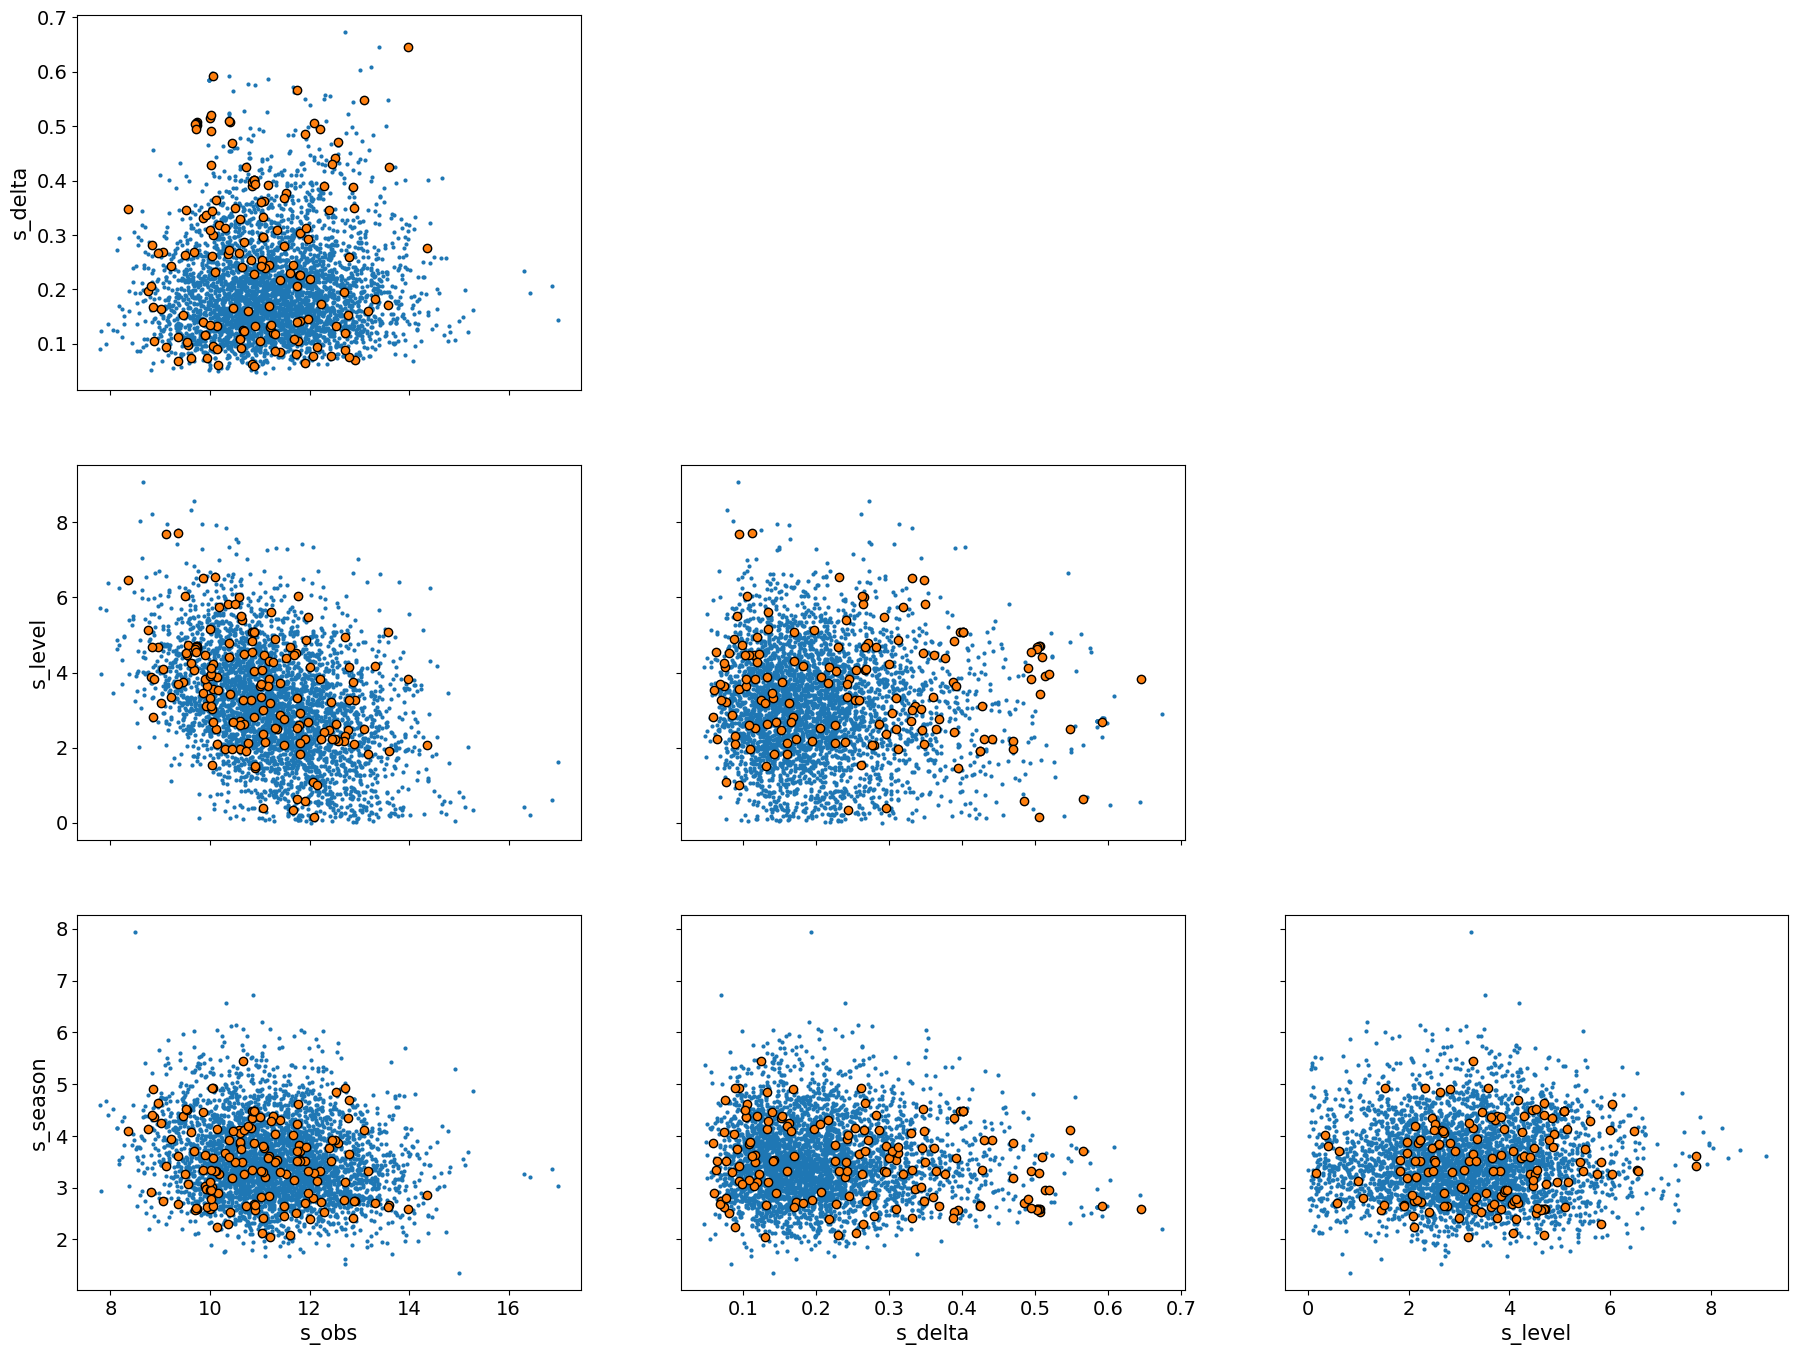

In [85]:
az.plot_pair(idata, var_names=("s_obs", "s_delta", "s_level", "s_season"), divergences=True)

In [ ]:
plt.plot(fitsum['seasonal[0]':'seasonal[98]']['mean'].values, color='b', linestyle="-")


In [ ]:
plt.fill_between(
    range(0,100),
    fitsum['delta[0]':'delta[99]']['hdi_97%'].values,
    fitsum['delta[0]':'delta[99]']['hdi_3%'].values,
    alpha=.3
    )
#plt.plot(fitsum['y_hat[0]':'y_hat[98]']['mean'].values, color='b', linestyle="--")
plt.plot(fitsum['delta[0]':'delta[98]']['mean'].values, color='g', linestyle="--")


In [ ]:
plt.fill_between(
    range(0,100),
    fitsum['y_hat[0]':'y_hat[99]']['hdi_97%'].values,
    fitsum['y_hat[0]':'y_hat[99]']['hdi_3%'].values,
    alpha=.3
    )
plt.plot(y, linestyle="--", marker="o", alpha=.4, color='r')
plt.plot(fitsum['y_hat[0]':'y_hat[98]']['mean'].values, color='b', linestyle="--")
plt.plot(fitsum['mu[0]':'mu[98]']['mean'].values, color='g', linestyle="-")
